<a href="https://colab.research.google.com/github/amrahmani/Machine-Learning/blob/main/Ch10_Variational%20Autoencoders%20(VAEs).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem 1**
**Applications of VAEs: Image Creation**

The MNIST dataset consists of grayscale images (28 pixels x 28 pixels) of handwritten digits (0-9). VAEs can be trained on this dataset to learn the underlying distribution of handwritten digits. This allows the VAE to generate entirely new, realistic-looking images of digits that were not present in the original dataset.

Starting training...
Epoch [1/20], Loss: 4142.8452
Epoch [2/20], Loss: 3340.9446
Epoch [3/20], Loss: 3047.2310
Epoch [4/20], Loss: 3612.9209
Epoch [5/20], Loss: 3194.0813
Epoch [6/20], Loss: 3321.3853
Epoch [7/20], Loss: 3259.4609
Epoch [8/20], Loss: 3194.9497
Epoch [9/20], Loss: 3226.9973
Epoch [10/20], Loss: 3044.3374
Epoch [11/20], Loss: 3254.9690
Epoch [12/20], Loss: 3118.2466
Epoch [13/20], Loss: 3367.1104
Epoch [14/20], Loss: 3499.4329
Epoch [15/20], Loss: 3292.5071
Epoch [16/20], Loss: 3090.0615
Epoch [17/20], Loss: 3164.2671
Epoch [18/20], Loss: 3193.0942
Epoch [19/20], Loss: 3197.4690
Epoch [20/20], Loss: 3087.4604
Training complete.


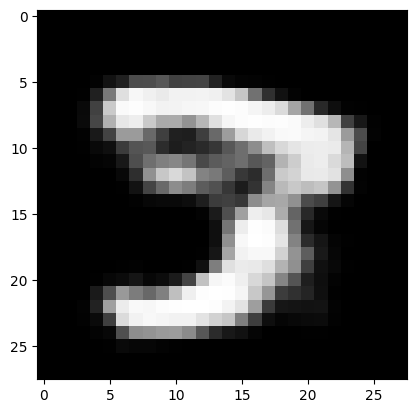

Generated a new image from the trained VAE.


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Define the VAE architecture
class VAE(nn.Module):
    def __init__(self, input_dim=784, h_dim=512, z_dim=16):
        super(VAE, self).__init__()

        # Encoder layers
        self.fc1 = nn.Linear(input_dim, h_dim)
        self.fc2 = nn.Linear(h_dim, 64)
        self.fc_mu = nn.Linear(64, z_dim)
        self.fc_log_var = nn.Linear(64, z_dim) # Common practice is to use log_var for stability

        # Decoder layers
        self.fc4 = nn.Linear(z_dim, 64)
        self.fc5 = nn.Linear(64, h_dim)
        self.fc6 = nn.Linear(h_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        # Generate a random tensor epsilon from a standard normal distribution (mean=0, std=1)
        epsilon = torch.randn_like(std)
        return mu + epsilon * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        h = F.relu(self.fc5(h))
        return torch.sigmoid(self.fc6(h))

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var

# Define the custom VAE loss function
def vae_loss(x_reconstructed, x, mu, log_var):
    # Reconstruction loss (Binary Cross-Entropy for MNIST)
    reconstruction_loss = F.binary_cross_entropy(x_reconstructed, x.view(-1, 784), reduction='sum')

    # KL Divergence loss
    # The formula for KL divergence loss is 0.5 * sum(1 + log(σ^2) - μ^2 - σ^2)
    # which can be rewritten using log_var as 0.5 * sum(1 + log_var - μ^2 - exp(log_var))
    kl_divergence_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var))

    return reconstruction_loss + kl_divergence_loss

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 10
batch_size = 64
learning_rate = 0.001

# Load and preprocess the MNIST dataset
dataset = datasets.MNIST(root='dataset/', train=True, transform=transforms.ToTensor(), download=True)
train_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# Initialize the model, optimizer, and loss function
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
print('Starting training...')
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(train_loader):
        x = x.to(device)

        # Forward pass
        x_reconstructed, mu, log_var = model(x)

        # Calculate loss
        loss = vae_loss(x_reconstructed, x, mu, log_var)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete.')

# Example of image creation (generation) after training
# We can sample a random vector from the latent space and decode it.
with torch.no_grad():
    z = torch.randn(1, 16).to(device)
    generated_image = model.decode(z).view(28, 28)

    plt.imshow(generated_image.cpu().numpy(), cmap='gray')
    plt.show()
    print('Generated a new image from the trained VAE.')

# **Problem 2**
Use a Variational Autoencoder (VAE) for denoising.
- a VAE with a feedforward network
- a Convolutional Variational Autoencoder (C-VAE)

**dataset**= https://www.kaggle.com/competitions/denoising-dirty-documents/data

# Read Kaggle Datasets in Google Colab

In [ ]:
!pip install -q kaggle
from google.colab import files
files.upload() # This will open a file picker. Select your kaggle.json file.
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls -al
!kaggle competitions download -c denoising-dirty-documents
!ls -al
!unzip *.zip -d ./data/
!unzip -q data/sampleSubmission.csv.zip -d data
!unzip -q data/test.zip -d data
!unzip -q data/train.zip -d data
!unzip -q data/train_cleaned.zip -d data
!ls -al ./data/

Saving kaggle.json to kaggle.json
total 16
drwxr-xr-x 1 root root 4096 Sep 16 00:58 .
drwxr-xr-x 1 root root 4096 Sep 16 00:56 ..
drwxr-xr-x 4 root root 4096 Sep  9 13:46 .config
drwxr-xr-x 1 root root 4096 Sep  9 13:46 sample_data
  0% 0.00/35.7M [00:00<?, ?B/s]
100% 35.7M/35.7M [00:00<00:00, 1.35GB/s]
total 36600
drwxr-xr-x 1 root root     4096 Sep 16 00:58 .
drwxr-xr-x 1 root root     4096 Sep 16 00:56 ..
drwxr-xr-x 4 root root     4096 Sep  9 13:46 .config
-rw-r--r-- 1 root root 37460781 Dec 11  2019 denoising-dirty-documents.zip
drwxr-xr-x 1 root root     4096 Sep  9 13:46 sample_data
Archive:  denoising-dirty-documents.zip
  inflating: ./data/sampleSubmission.csv.zip  
  inflating: ./data/test.zip         
  inflating: ./data/train.zip        
  inflating: ./data/train_cleaned.zip  
total 239472
drwxr-xr-x 5 root root      4096 Sep 16 00:58 .
drwxr-xr-x 1 root root      4096 Sep 16 00:58 ..
-rw-r--r-- 1 root root 186373233 May  1  2015 sampleSubmission.csv
-rw-r--r-- 1 root root 

A VAE with a feedforward network

Starting training...
Epoch [1/10], Loss: 127161566494720.0000
Epoch [2/10], Loss: 777564.8750
Epoch [3/10], Loss: 165648.5938
Epoch [4/10], Loss: 138649.9844
Epoch [5/10], Loss: 135907.1094
Epoch [6/10], Loss: 142334.3281
Epoch [7/10], Loss: 133756.7344
Epoch [8/10], Loss: 121716.9219
Epoch [9/10], Loss: 118060.1406
Epoch [10/10], Loss: 125795.8516
Training complete.


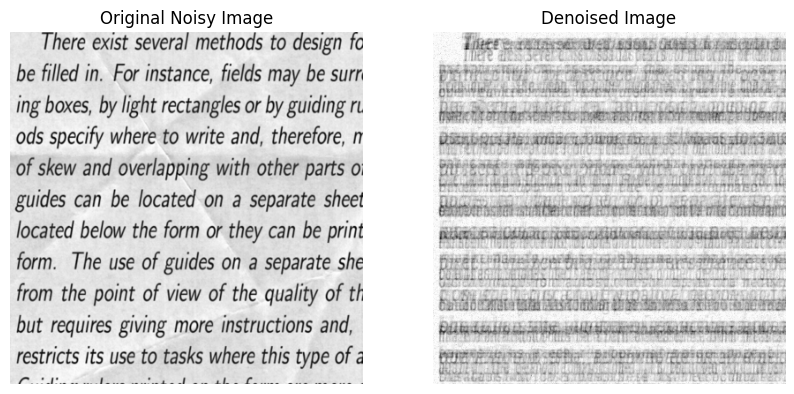

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from glob import glob
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
input_dim = 400 * 400  # Dimensions of the images (400x400)
h_dim = 256  # Hidden layer dimension
z_dim = 64   # Latent space dimension
num_epochs = 10
batch_size = 16
learning_rate = 0.001

# Define the custom dataset
class DenoisingDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_paths = sorted(glob(os.path.join(noisy_dir, '*.png')))
        self.clean_paths = sorted(glob(os.path.join(clean_dir, '*.png')))
        self.transform = transform

    def __len__(self):
        return len(self.noisy_paths)

    def __getitem__(self, idx):
        noisy_image = Image.open(self.noisy_paths[idx]).convert("L")  # Convert to grayscale
        clean_image = Image.open(self.clean_paths[idx]).convert("L")  # Convert to grayscale

        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)

        return noisy_image, clean_image

# Define the VAE architecture using a feedforward network
class VAE(nn.Module):
    def __init__(self, input_dim, h_dim, z_dim):
        super(VAE, self).__init__()

        # Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, h_dim // 2),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(h_dim // 2, z_dim)
        self.fc_log_var = nn.Linear(h_dim // 2, z_dim)

        # Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, h_dim // 2),
            nn.ReLU(),
            nn.Linear(h_dim // 2, h_dim),
            nn.ReLU(),
            nn.Linear(h_dim, input_dim),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x.view(-1, input_dim))
        z = self.reparameterize(mu, log_var)
        x_reconstructed = self.decode(z)
        return x_reconstructed, mu, log_var

# Define the VAE loss function
def vae_loss(x_reconstructed, x, mu, log_var):
    reconstruction_loss = F.mse_loss(x_reconstructed, x.view(-1, input_dim), reduction='sum')
    kl_divergence_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - torch.exp(log_var))

    return reconstruction_loss + kl_divergence_loss

# Load and preprocess the dataset
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
])

train_noisy_dir = './data/train/'
train_clean_dir = './data/train_cleaned/'

denoising_dataset = DenoisingDataset(train_noisy_dir, train_clean_dir, transform=transform)
train_loader = DataLoader(dataset=denoising_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model and optimizer
model = VAE(input_dim, h_dim, z_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
print('Starting training...')
for epoch in range(num_epochs):
    for i, (noisy_img, clean_img) in enumerate(train_loader):
        noisy_img = noisy_img.to(device)
        clean_img = clean_img.to(device)

        # Forward pass
        x_reconstructed, mu, log_var = model(noisy_img)

        # Calculate loss
        loss = vae_loss(x_reconstructed, clean_img, mu, log_var)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete.')

# --- New section to visualize denoising ---

def denoise_image(model, noisy_img_tensor):
    model.eval()
    with torch.no_grad():
        noisy_img_tensor = noisy_img_tensor.to(device).view(-1, input_dim)
        z = model.reparameterize(*model.encode(noisy_img_tensor))
        denoised_image = model.decode(z)
        return denoised_image.view(400, 400).cpu()

# Get a sample noisy and clean image from the dataset
noisy_sample, clean_sample = denoising_dataset[0]

# Pass the noisy sample through the trained model to get the denoised image
denoised_image_tensor = denoise_image(model, noisy_sample)

# Plot the original noisy and denoised images side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(noisy_sample.squeeze().numpy(), cmap='gray')
axes[0].set_title('Original Noisy Image')
axes[0].axis('off')

axes[1].imshow(denoised_image_tensor.numpy(), cmap='gray')
axes[1].set_title('Denoised Image')
axes[1].axis('off')

plt.show()

A Convolutional Variational Autoencoder (C-VAE)

Starting training...
Epoch [1/50], Loss: 626244.5625
Epoch [2/50], Loss: 527726.2500
Epoch [3/50], Loss: 512378.0000
Epoch [4/50], Loss: 470164.7812
Epoch [5/50], Loss: 455616.1250
Epoch [6/50], Loss: 426107.4375
Epoch [7/50], Loss: 403268.2500
Epoch [8/50], Loss: 396352.2500
Epoch [9/50], Loss: 364924.8750
Epoch [10/50], Loss: 354965.4375
Epoch [11/50], Loss: 349223.2500
Epoch [12/50], Loss: 331804.2188
Epoch [13/50], Loss: 332947.1250
Epoch [14/50], Loss: 322099.5000
Epoch [15/50], Loss: 317624.7500
Epoch [16/50], Loss: 315410.2812
Epoch [17/50], Loss: 299600.8125
Epoch [18/50], Loss: 297304.3438
Epoch [19/50], Loss: 294874.6562
Epoch [20/50], Loss: 299351.5625
Epoch [21/50], Loss: 286222.1875
Epoch [22/50], Loss: 291503.1562
Epoch [23/50], Loss: 271123.0312
Epoch [24/50], Loss: 285831.1875
Epoch [25/50], Loss: 282122.6875
Epoch [26/50], Loss: 276482.0000
Epoch [27/50], Loss: 265826.3750
Epoch [28/50], Loss: 261988.6250
Epoch [29/50], Loss: 253247.4531
Epoch [30/50], Loss: 260049.703

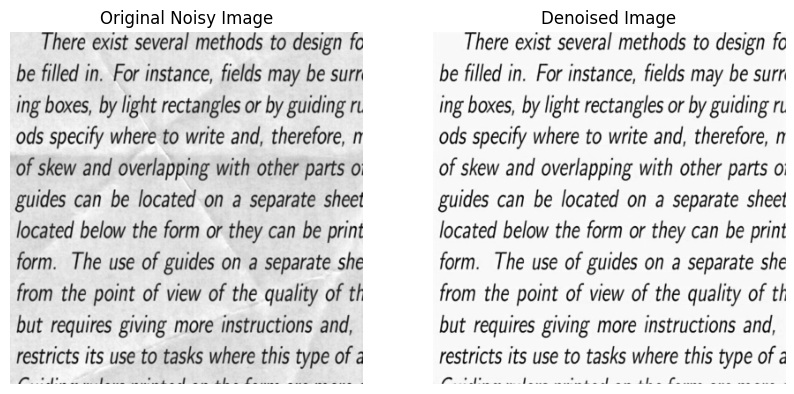

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
from glob import glob
import matplotlib.pyplot as plt

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 50
batch_size = 8
learning_rate = 1e-4

# Define the custom dataset
class DenoisingDataset(Dataset):
    def __init__(self, noisy_dir, clean_dir, transform=None):
        self.noisy_paths = sorted(glob(os.path.join(noisy_dir, '*.png')))
        self.clean_paths = sorted(glob(os.path.join(clean_dir, '*.png')))
        self.transform = transform

    def __len__(self):
        return len(self.noisy_paths)

    def __getitem__(self, idx):
        noisy_image = Image.open(self.noisy_paths[idx]).convert("L")
        clean_image = Image.open(self.clean_paths[idx]).convert("L")

        if self.transform:
            noisy_image = self.transform(noisy_image)
            clean_image = self.transform(clean_image)

        return noisy_image, clean_image

# The U-Net Architecture
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Helper function for convolutional blocks
        def conv_block(in_channels, out_channels):
            return nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(out_channels),
                nn.ReLU(inplace=True)
            )

        # Encoder
        self.e1 = conv_block(1, 64)
        self.e2 = conv_block(64, 128)
        self.e3 = conv_block(128, 256)
        self.e4 = conv_block(256, 512)

        # Latent Space (Bottleneck)
        self.bottleneck = conv_block(512, 1024)

        # Decoder with new conv_blocks for correct channel sizes
        self.d1_upconv = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d1_conv = conv_block(512 + 512, 512)

        self.d2_upconv = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d2_conv = conv_block(256 + 256, 256)

        self.d3_upconv = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d3_conv = conv_block(128 + 128, 128)

        self.d4_upconv = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d4_conv = conv_block(64 + 64, 64)

        # Final output layer
        self.out_conv = nn.Conv2d(64, 1, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)


    def forward(self, x):
        # Encoder
        e1_out = self.e1(x)
        e2_in = self.pool(e1_out)
        e2_out = self.e2(e2_in)
        e3_in = self.pool(e2_out)
        e3_out = self.e3(e3_in)
        e4_in = self.pool(e3_out)
        e4_out = self.e4(e4_in)

        # Bottleneck
        bottleneck_in = self.pool(e4_out)
        bottleneck_out = self.bottleneck(bottleneck_in)

        # Decoder with skip connections
        d1_out = self.d1_upconv(bottleneck_out)
        d1_out = torch.cat((e4_out, d1_out), dim=1) # Concatenate along the channel dimension
        d1_out = self.d1_conv(d1_out)

        d2_out = self.d2_upconv(d1_out)
        d2_out = torch.cat((e3_out, d2_out), dim=1)
        d2_out = self.d2_conv(d2_out)

        d3_out = self.d3_upconv(d2_out)
        d3_out = torch.cat((e2_out, d3_out), dim=1)
        d3_out = self.d3_conv(d3_out)

        d4_out = self.d4_upconv(d3_out)
        d4_out = torch.cat((e1_out, d4_out), dim=1)
        d4_out = self.d4_conv(d4_out)

        # Output
        return torch.sigmoid(self.out_conv(d4_out))

# Loss Function
def bce_loss(x_reconstructed, x_clean):
    return F.binary_cross_entropy(x_reconstructed, x_clean, reduction='sum')

# Load and preprocess the dataset
transform = transforms.Compose([
    transforms.Resize((400, 400)),
    transforms.ToTensor()
])

train_noisy_dir = './data/train/'
train_clean_dir = './data/train_cleaned/'

denoising_dataset = DenoisingDataset(train_noisy_dir, train_clean_dir, transform=transform)
train_loader = DataLoader(dataset=denoising_dataset, batch_size=batch_size, shuffle=True)

# Initialize the model and optimizer
model = UNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
print('Starting training...')
for epoch in range(num_epochs):
    for i, (noisy_img, clean_img) in enumerate(train_loader):
        noisy_img = noisy_img.to(device)
        clean_img = clean_img.to(device)

        x_reconstructed = model(noisy_img)
        loss = bce_loss(x_reconstructed, clean_img)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

print('Training complete.')

# --- Section to visualize denoising ---

def denoise_image(model, noisy_img_tensor):
    model.eval()
    with torch.no_grad():
        x_reconstructed = model(noisy_img_tensor)
        return x_reconstructed.squeeze().cpu()

# Get a sample noisy and clean image from the dataset
noisy_sample, clean_sample = denoising_dataset[0]
noisy_sample_batch = noisy_sample.unsqueeze(0).to(device)

# Pass the noisy sample through the trained model
denoised_image_tensor = denoise_image(model, noisy_sample_batch)

# Plot the original noisy and denoised images side-by-side
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(noisy_sample.squeeze().numpy(), cmap='gray')
axes[0].set_title('Original Noisy Image')
axes[0].axis('off')

axes[1].imshow(denoised_image_tensor.numpy(), cmap='gray')
axes[1].set_title('Denoised Image')
axes[1].axis('off')

plt.show()

# **Problem 3**
Write the Python code for a VAE-based recommendation system using the MovieLens 25M Datase

In [ ]:
!pip install -q kaggle
import kagglehub
from google.colab import files
files.upload() # This will open a file picker. Select your kaggle.json file.
!mkdir -p ~/.kaggle/
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
path = kagglehub.dataset_download("garymk/movielens-25m-dataset")
print("Path to dataset files:", path)
!cp -r {path} /content/movielens25m
!ls /content/movielens25m

Saving kaggle.json to kaggle.json
Using Colab cache for faster access to the 'movielens-25m-dataset' dataset.
Path to dataset files: /kaggle/input/movielens-25m-dataset
ml-25m	movielens-25m-dataset


In [ ]:
# Download latest version
path = kagglehub.dataset_download("garymk/movielens-25m-dataset")
print("Path to dataset files:", path)
!cp -r {path} /content/movielens25m
!ls /content/movielens25m

Using Colab cache for faster access to the 'movielens-25m-dataset' dataset.
Path to dataset files: /kaggle/input/movielens-25m-dataset


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# --- Data Loading and Preprocessing ---
print("Loading and preprocessing data...")

# Corrected path to the ratings file
ratings_df = pd.read_csv('/content/movielens25m/ml-25m/ratings.csv')

# Sample a smaller fraction of the data to avoid RAM crash.
ratings_df = ratings_df.sample(frac=0.005, random_state=42)

# Filter out users and movies with too few ratings.
user_counts = ratings_df['userId'].value_counts()
movie_counts = ratings_df['movieId'].value_counts()

# Keep only users with at least 10 ratings and movies with at least 5 ratings
min_user_ratings = 10
min_movie_ratings = 5
ratings_df = ratings_df[ratings_df['userId'].isin(user_counts[user_counts >= min_user_ratings].index)]
ratings_df = ratings_df[ratings_df['movieId'].isin(movie_counts[movie_counts >= min_movie_ratings].index)]


# Create a mapping for user and item IDs to continuous integers
user_ids = ratings_df['userId'].unique().tolist()
user_map = {id: i for i, id in enumerate(user_ids)}
ratings_df['userId'] = ratings_df['userId'].map(user_map)

movie_ids = ratings_df['movieId'].unique().tolist()
movie_map = {id: i for i, id in enumerate(movie_ids)}
ratings_df['movieId'] = ratings_df['movieId'].map(movie_map)

# Get number of users and movies
num_users = len(user_ids)
num_movies = len(movie_ids)
print(f"Number of users after filtering: {num_users}")
print(f"Number of movies after filtering: {num_movies}")

# Create implicit feedback matrix: 1 if user rated a movie, 0 otherwise
user_movie_matrix = torch.zeros(num_users, num_movies, dtype=torch.float32)
for _, row in ratings_df.iterrows():
    user_movie_matrix[int(row['userId']), int(row['movieId'])] = 1.0

# Split data into training and validation sets
train_matrix, val_matrix = train_test_split(user_movie_matrix.numpy(), test_size=0.2, random_state=42)
train_matrix = torch.tensor(train_matrix, dtype=torch.float32).to(device)
val_matrix = torch.tensor(val_matrix, dtype=torch.float32).to(device)

# --- VAE Model Definition ---
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        # Encoder
        self.encoder_linear1 = nn.Linear(input_dim, hidden_dim)
        self.encoder_linear2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc_mu = nn.Linear(hidden_dim // 2, latent_dim)
        self.fc_log_var = nn.Linear(hidden_dim // 2, latent_dim)

        # Decoder
        self.decoder_linear1 = nn.Linear(latent_dim, hidden_dim // 2)
        self.decoder_linear2 = nn.Linear(hidden_dim // 2, hidden_dim)
        self.decoder_output = nn.Linear(hidden_dim, input_dim)

    def encode(self, x):
        h = F.relu(self.encoder_linear1(x))
        h = F.relu(self.encoder_linear2(h))
        mu = self.fc_mu(h)
        log_var = self.fc_log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.decoder_linear1(z))
        h = F.relu(self.decoder_linear2(h))
        return torch.sigmoid(self.decoder_output(h))

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mu, log_var

# --- Training and Loss Function ---
def vae_loss(reconstruction, x, mu, log_var):
    # BCE loss for implicit feedback
    reconstruction_loss = F.binary_cross_entropy(reconstruction, x, reduction='sum')
    # KL divergence loss
    kl_divergence_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence_loss

# Hyperparameters
input_dim = num_movies
hidden_dim = 600
latent_dim = 200
learning_rate = 1e-3
num_epochs = 20

# Initialize model and optimizer
model = VAE(input_dim, hidden_dim, latent_dim).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Create DataLoader for training
train_dataset = torch.utils.data.TensorDataset(train_matrix)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

print("Starting training...")
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        data = batch[0]
        reconstruction, mu, log_var = model(data)
        loss = vae_loss(reconstruction, data, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")

print("Training complete.")

# --- Generate Recommendations ---
print("Generating recommendations for a sample user...")
model.eval()
with torch.no_grad():
    # Pick a random user from the validation set
    user_idx = np.random.randint(0, val_matrix.shape[0])
    user_data = val_matrix[user_idx, :].unsqueeze(0)

    # Get the model's predicted ratings (reconstructions)
    reconstructed_ratings, _, _ = model(user_data)

    # Identify movies the user has not interacted with
    unwatched_movies = (user_data == 0).squeeze()

    # Get the reconstructed ratings for only the unwatched movies
    predicted_scores = reconstructed_ratings.squeeze()[unwatched_movies]

    # Get the top 10 recommended movie indices
    top_10_indices = torch.topk(predicted_scores, 10).indices

    # To get the original movie IDs, you'd need the reverse map
    # movie_rev_map = {i: id for id, i in movie_map.items()}
    # recommended_movie_ids = [movie_rev_map[idx.item()] for idx in top_10_indices]

    print("\nTop 10 recommended movie indices for a random user:")
    print(top_10_indices)

Using device: cuda
Loading and preprocessing data...
Number of users after filtering: 702
Number of movies after filtering: 3057
Starting training...
Epoch [1/20], Loss: 1375.7558
Epoch [2/20], Loss: 115.1205
Epoch [3/20], Loss: 113.4466
Epoch [4/20], Loss: 96.7595
Epoch [5/20], Loss: 83.7485
Epoch [6/20], Loss: 72.6979
Epoch [7/20], Loss: 67.7054
Epoch [8/20], Loss: 66.4115
Epoch [9/20], Loss: 65.3368
Epoch [10/20], Loss: 64.6559
Epoch [11/20], Loss: 64.1099
Epoch [12/20], Loss: 63.8191
Epoch [13/20], Loss: 63.5575
Epoch [14/20], Loss: 63.3077
Epoch [15/20], Loss: 63.1245
Epoch [16/20], Loss: 63.0964
Epoch [17/20], Loss: 63.0171
Epoch [18/20], Loss: 63.0445
Epoch [19/20], Loss: 62.9242
Epoch [20/20], Loss: 62.9509
Training complete.
Generating recommendations for a sample user...

Top 10 recommended movie indices for a random user:
tensor([1601, 1294,   33,  943,  171,  802,   91, 1491,  796,  785],
       device='cuda:0')


**Practice:**

**Task 1:** **Anomaly Detection with VAEs**

- Learning Normal Data: VAEs learn to reconstruct the normal patterns of data by training exclusively on non-anomalous examples.

- Identifying Anomalies: When presented with an anomaly, the VAE struggles to reconstruct it because it falls outside the learned patterns.

- High Reconstruction Error: This difficulty results in a high reconstruction error, which is the key indicator of a potential outlier.

- **Assignment:** You should find a suitable Kaggle dataset (e.g., credit card fraud) to demonstrate this process.